In [83]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
# Set Tensorflow as Keras backend 
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Keras import(s)
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam

# Local import(s) -- after Keras backend is set
import ops
import plots
import layers
reload(ops); reload(plots); reload(layers); 

# Reproducibility
np.random.seed(42)

# Understanding inputs

In [2]:
df = pd.read_hdf('data/data.h5')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143878 entries, 0 to 143877
Data columns (total 12 columns):
y1_pt           143878 non-null float64
y1_eta          143878 non-null float64
y1_phi          143878 non-null float64
y2_pt           143878 non-null float64
y2_eta          143878 non-null float64
y2_phi          143878 non-null float64
signal          143878 non-null int64
myy             143878 non-null float64
train           143878 non-null float64
weight_adv      143878 non-null float64
weight_test     143878 non-null float64
weight_train    143878 non-null float64
dtypes: float64(11), int64(1)
memory usage: 14.3 MB


In [4]:
df.head(10)

,y1_pt,y1_eta,y1_phi,y2_pt,y2_eta,y2_phi,signal,myy,train,weight_adv,weight_test,weight_train
0,44.4581,-2.226330,-1.360920,37.6765,-1.723970,1.456820,0,83.4125,0.0,0.840986,0.846175,0.108258
1,87.6833,0.186689,2.906570,45.0523,-0.185495,0.500284,0,119.6390,1.0,0.021285,0.634414,0.161455
2,61.0716,-1.236300,-0.125045,39.3372,-0.209543,2.127030,0,102.9270,1.0,0.440384,0.148416,0.214117
3,69.6352,-1.728330,-1.449530,61.0498,-0.972100,0.911809,0,130.7470,1.0,0.690270,0.044335,0.648414
4,75.1040,0.204316,-1.809570,45.7441,1.212070,2.143840,0,124.0730,0.0,0.266515,0.150754,0.127705
5,116.8910,0.497827,2.217280,51.2143,1.180580,0.302775,0,137.5080,1.0,0.116244,0.257357,0.134536
6,99.8760,-1.779970,-0.713627,51.4623,-2.366220,2.156100,0,148.3220,0.0,0.342601,0.306628,0.202323
7,59.7852,0.345871,2.725460,38.7535,-0.921116,0.672731,0,105.0030,1.0,0.866811,0.258748,0.824593
8,66.4424,-0.400502,1.415400,26.3871,1.027500,-1.101240,0,102.8380,1.0,0.397445,0.437521,0.711287
9,66.2466,0.890965,-1.978890,60.7096,1.153100,1.328450,0,127.4950,1.0,0.616976,0.906462,0.949525


In [5]:
df.tail(10)

,y1_pt,y1_eta,y1_phi,y2_pt,y2_eta,y2_phi,signal,myy,train,weight_adv,weight_test,weight_train
143868,113.0590,-0.134845,-0.036826,40.3493,-0.747128,-2.172440,1,125.585,0.0,0.467271,0.394586,0.356248
143869,70.6902,-1.259320,0.608239,45.9960,0.228756,-1.146410,1,127.759,0.0,0.411209,0.516605,0.914603
143870,111.6320,-1.011580,-1.320510,36.4369,-1.145460,1.816920,1,127.840,1.0,0.708818,0.776099,0.051556
143871,78.7135,-1.260990,0.909021,40.9408,0.153966,2.876390,1,128.599,0.0,0.136807,0.501091,0.562119
143872,127.7610,-0.602620,0.509282,39.0690,-0.521184,-1.642940,1,124.495,1.0,0.824896,0.455117,0.861641
143873,73.7728,-0.342338,-1.734090,59.5318,0.407436,2.444840,1,125.845,1.0,0.024242,0.530662,0.024512
143874,122.8570,0.293571,1.362320,83.9156,0.478674,0.059255,1,124.574,0.0,0.251137,0.434636,0.463706
143875,105.9720,-0.107960,-1.506360,42.9836,-0.339329,2.404580,1,126.093,0.0,0.776630,0.731860,0.803196
143876,119.3200,1.556910,-3.058980,88.4842,2.261320,2.194880,1,125.267,1.0,0.796845,0.371263,0.769649
143877,86.4935,-1.068260,2.391140,64.7493,-0.071391,0.895296,1,128.077,1.0,0.766116,0.102245,0.684443


In [6]:
df.describe()

,y1_pt,y1_eta,y1_phi,y2_pt,y2_eta,y2_phi,signal,myy,train,weight_adv,weight_test,weight_train
count,143878.000000,143878.000000,143878.000000,143878.000000,143878.000000,143878.000000,143878.000000,143878.000000,143878.000000,1.438780e+05,143878.000000,143878.000000
mean,104.319232,0.002262,0.007003,54.298384,-0.000157,0.002524,0.599709,122.750510,0.499632,4.989873e-01,0.499700,0.498359
std,59.900432,1.011561,1.815994,26.436228,1.050211,1.815481,0.489959,28.653947,0.500002,2.886328e-01,0.289119,0.288777
min,23.063900,-2.392910,-3.141570,22.000100,-2.390100,-3.141560,0.000000,2.586820,0.000000,2.748452e-07,0.000018,0.000002
25%,68.486300,-0.710936,-1.573757,38.222750,-0.748009,-1.575688,0.000000,117.279250,0.000000,2.482197e-01,0.248613,0.247828
50%,88.407450,0.004418,0.016679,48.017150,-0.000405,0.004735,1.000000,124.680000,0.000000,5.003549e-01,0.499879,0.497096
75%,119.618250,0.715653,1.581190,61.376475,0.748907,1.575338,1.000000,126.679750,1.000000,7.486186e-01,0.749366,0.748686
max,1115.040000,2.397520,3.141480,548.742000,2.390110,3.141580,1.000000,1296.500000,1.000000,9.999855e-01,0.999999,0.999979


### input distributions 

In [7]:
m = df['myy'].values.ravel()
X = df[['y1_pt', 'y2_pt', 'y1_eta', 'y2_eta', 'y1_phi', 'y2_phi']]

In [8]:
m.shape

(143878,)

In [9]:
y = df['signal']

In [44]:
y.values.reshape(-1,1).shape

(143878, 1)

In [11]:
X.values.shape

(143878, 6)

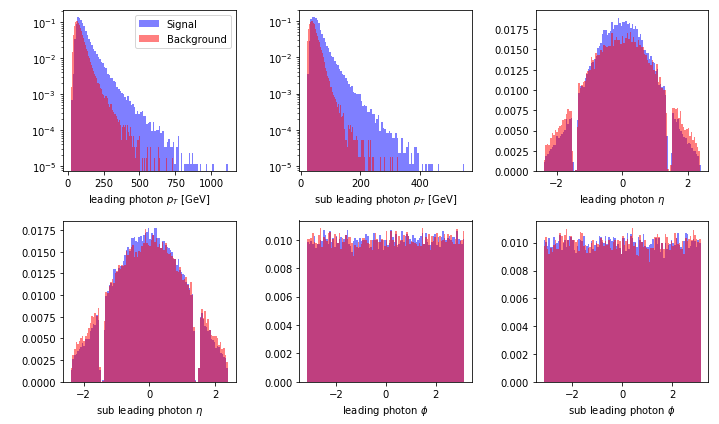

In [12]:
fig, axes = plt.subplots(2,3, figsize =(10,6))
names = ['leading photon $p_T$ [GeV]', 'sub leading photon $p_T$ [GeV]', 'leading photon $\\eta$',\
         'sub leading photon $\\eta$', 'leading photon $\\phi$', 'sub leading photon $\\phi$']

for ix, (ax, nm) in enumerate (zip(axes.flatten(), names)):
    plots.distribution(y.values.ravel(), ix, X.values, bins=100, xlabel=nm, ylabel=' ', ax=ax, legend=(ix == 0))
    
axes[0][0].semilogy()
axes[0][1].semilogy() 
fig.tight_layout()

### background correlations

In [13]:
df_in_out = df[['y1_pt', 'y2_pt', 'y1_eta', 'y2_eta', 'y1_phi', 'y2_phi', 'myy', 'signal']]
df_bkg = df_in_out[df_in_out['signal'] == 0]

In [14]:
df_in_out_scaled = df_in_out.copy()
y1_pt_scaled = df_in_out['y1_pt']/df_in_out['myy']
y2_pt_scaled = df_in_out['y2_pt']/df_in_out['myy']
df_in_out_scaled['y1_pt'] = y1_pt_scaled
df_in_out_scaled['y2_pt'] = y2_pt_scaled
df_in_out_scaled = df_in_out_scaled.rename(index=str, columns={'y1_pt':'y1_pt_scaled', 'y2_pt':'y2_pt_scaled'})
df_bkg_scaled = df_in_out_scaled[df_in_out_scaled['signal'] == 0]

In [15]:
df_bkg = df_bkg.drop(columns='signal')
df_bkg_scaled = df_bkg_scaled.drop(columns='signal')

#### correlations w/o scaling by myy

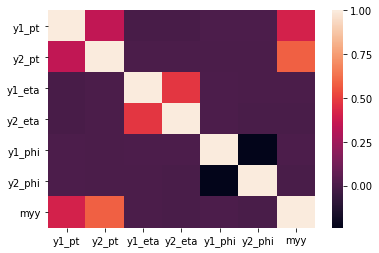

In [16]:
sns.heatmap(df_bkg.corr())

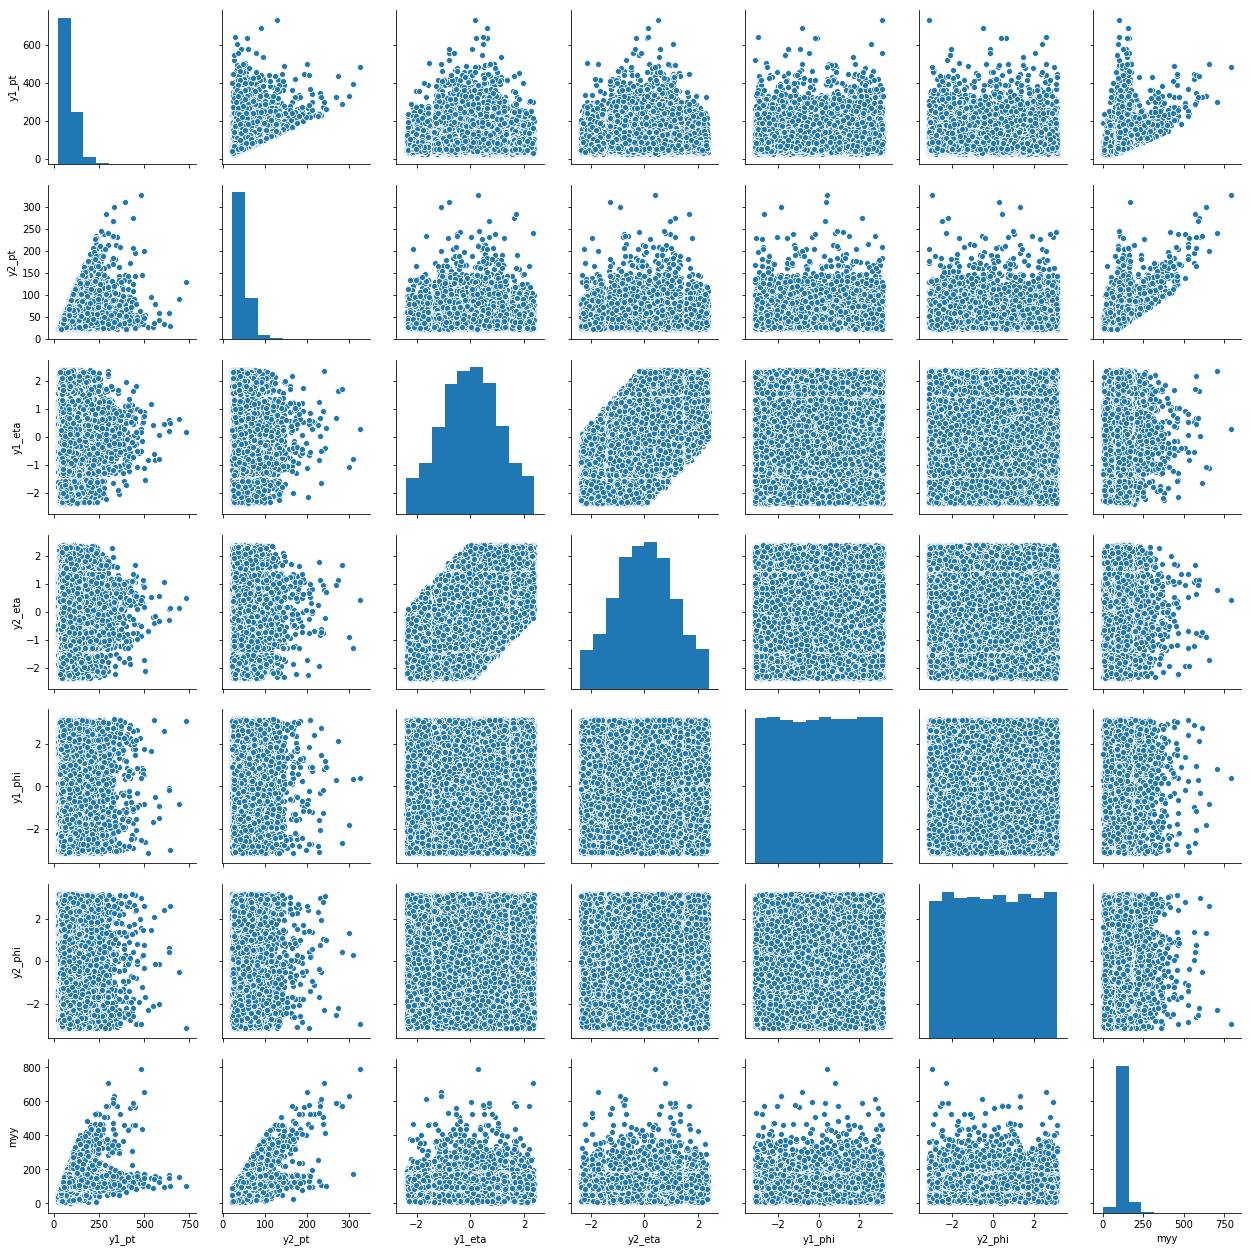

In [17]:
sns.pairplot(df_bkg)

#### check the correlation after scaling with myy

In [18]:
df_bkg_scaled.head()

,y1_pt_scaled,y2_pt_scaled,y1_eta,y2_eta,y1_phi,y2_phi,myy
0,0.532991,0.451689,-2.226330,-1.723970,-1.360920,1.456820,83.4125
1,0.732899,0.376569,0.186689,-0.185495,2.906570,0.500284,119.6390
2,0.593349,0.382185,-1.236300,-0.209543,-0.125045,2.127030,102.9270
3,0.532595,0.466931,-1.728330,-0.972100,-1.449530,0.911809,130.7470
4,0.605321,0.368687,0.204316,1.212070,-1.809570,2.143840,124.0730


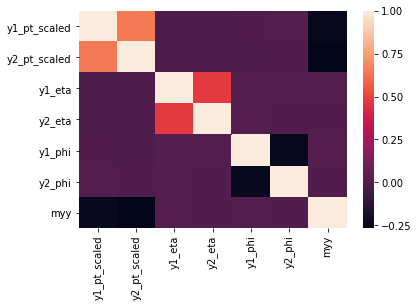

In [19]:
sns.heatmap(df_bkg_scaled.corr())

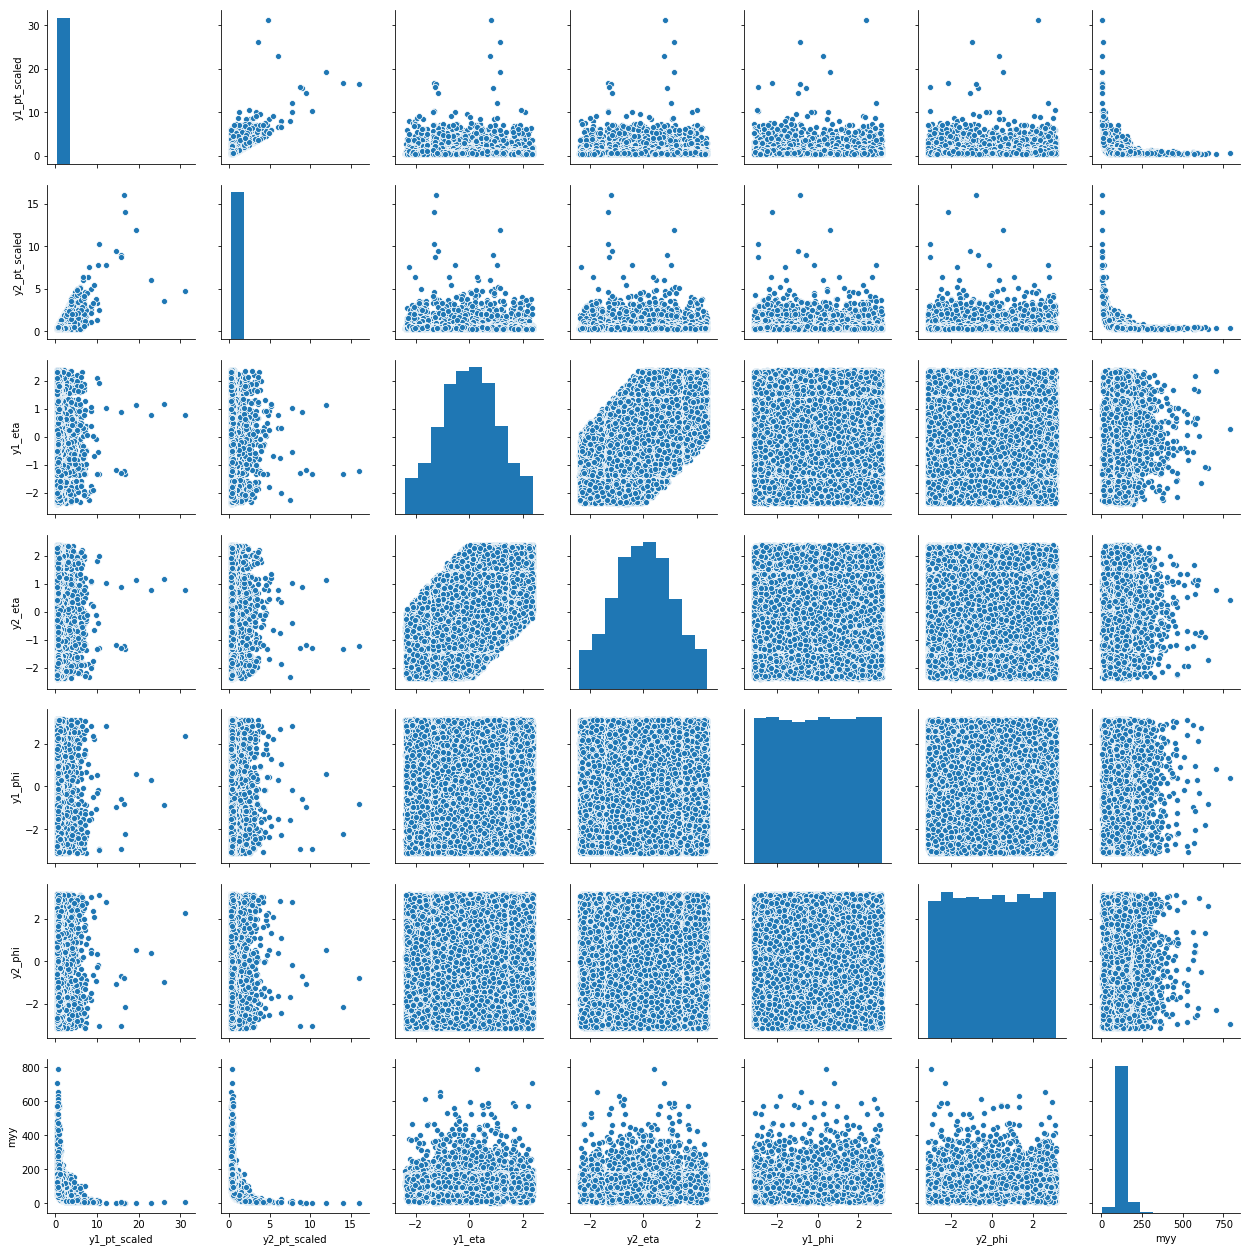

In [20]:
sns.pairplot(df_bkg_scaled)

# Classification

In [21]:
def clf_dense(nfeatures):
    # input layer
    i = Input(shape=(nfeatures,))
    # hidden layers
    x = Dense(32, activation='relu')(i)
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    # output
    o = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=i, outputs=o, name='clf_dense')
    

### input preprocessing 

In [22]:
# X = df[['y1_pt', 'y2_pt', 'y1_eta', 'y2_eta', 'y1_phi', 'y2_phi']]
# y = df['signal']
X_myy = df_in_out_scaled[['y1_pt_scaled', 'y2_pt_scaled', 'y1_eta', 'y2_eta', 'y1_phi', 'y2_phi']]

In [23]:
X.head(5)

,y1_pt,y2_pt,y1_eta,y2_eta,y1_phi,y2_phi
0,44.4581,37.6765,-2.226330,-1.723970,-1.360920,1.456820
1,87.6833,45.0523,0.186689,-0.185495,2.906570,0.500284
2,61.0716,39.3372,-1.236300,-0.209543,-0.125045,2.127030
3,69.6352,61.0498,-1.728330,-0.972100,-1.449530,0.911809
4,75.1040,45.7441,0.204316,1.212070,-1.809570,2.143840


In [24]:
X_myy.head(5)

,y1_pt_scaled,y2_pt_scaled,y1_eta,y2_eta,y1_phi,y2_phi
0,0.532991,0.451689,-2.226330,-1.723970,-1.360920,1.456820
1,0.732899,0.376569,0.186689,-0.185495,2.906570,0.500284
2,0.593349,0.382185,-1.236300,-0.209543,-0.125045,2.127030
3,0.532595,0.466931,-1.728330,-0.972100,-1.449530,0.911809
4,0.605321,0.368687,0.204316,1.212070,-1.809570,2.143840


In [25]:
y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: signal, dtype: int64

In [26]:
y.tail(5)

143873    1
143874    1
143875    1
143876    1
143877    1
Name: signal, dtype: int64

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()
sc = scaler.fit(X, y)
X_sc = scaler.transform(X) 

In [29]:
scaler_myy = StandardScaler()
sc_myy = scaler_myy.fit(X_myy, y)
X_myy_sc = scaler_myy.transform(X_myy) 

## train where pt not scaled by myy

In [65]:
X_train, X_test, y_train, y_test, m_train, m_test = train_test_split(X_sc, df['signal'], df['myy'])

In [34]:
# X_myy_train, y_myy_train, m_myy_train, X_myy_test, y_myy_test, m_myy_test = train_test_split(X_myy_sc, df['signal'], df['myy'], random_state=42)

In [66]:
X_train.shape

(107908, 6)

In [67]:
X_test.shape

(35970, 6)

In [68]:
y_train.shape

(107908,)

In [69]:
y_test.shape

(35970,)

In [70]:
nb_features = X.shape[1]

In [71]:
clf = clf_dense(nb_features)
clf.compile('adam', loss='binary_crossentropy')
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 2,369
Trainable params: 2,369
Non-trainable params: 0
_________________________________________________________________


In [72]:
clf_fit = clf.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Train on 86326 samples, validate on 21582 samples
Epoch 1/10
86326/86326 [==============================] - 3s 29us/step - loss: 0.5623 - val_loss: 0.5330
Epoch 2/10
86326/86326 [==============================] - 2s 26us/step - loss: 0.5231 - val_loss: 0.5158
Epoch 3/10
86326/86326 [==============================] - 2s 27us/step - loss: 0.5061 - val_loss: 0.4950
Epoch 4/10
86326/86326 [==============================] - 2s 27us/step - loss: 0.4890 - val_loss: 0.4794
Epoch 5/10
86326/86326 [==============================] - 2s 26us/step - loss: 0.4638 - val_loss: 0.4428
Epoch 6/10
86326/86326 [==============================] - 2s 27us/step - loss: 0.4252 - val_loss: 0.4074
Epoch 7/10
86326/86326 [==============================] - 2s 28us/step - loss: 0.3930 - val_loss: 0.3829
Epoch 8/10
86326/86326 [==============================] - 3s 35us/step - loss: 0.3690 - val_loss: 0.3583
Epoch 9/10
86326/86326 [==============================] - 3s 29us/step - loss: 0.3503 - val_loss: 0.3496
Epoch

In [73]:
y_pred = clf.predict(X_test)

plots.py:159: RuntimeWarning: Mean of empty slice.
  profiles[ix].append(y[msk].mean())


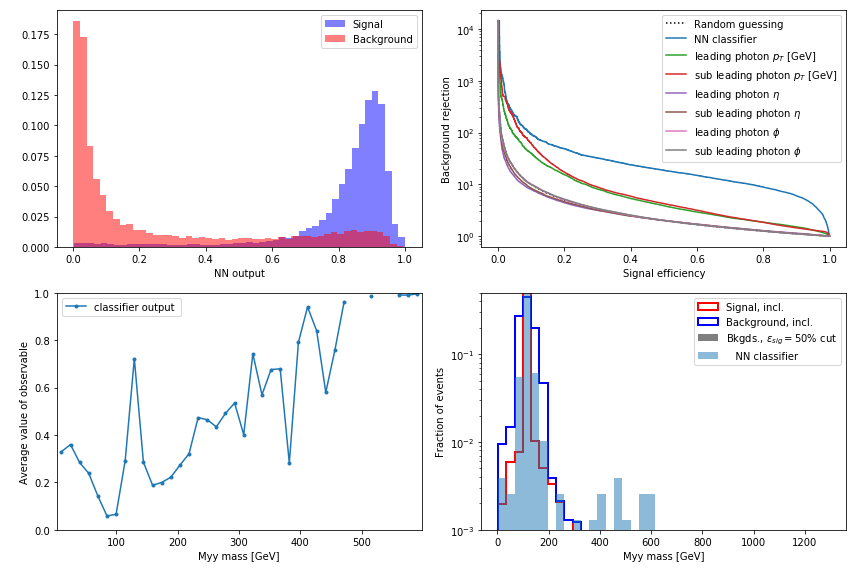

In [84]:
# Create axes
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes = axes.flatten()

# NN output
plots.distribution(y_test, y_pred, xlabel="NN output", ylabel=' ',ax=axes[0])

# ROC curve
plots.roc(y_test, [y_pred, None] + map(np.array, X_test.T.tolist()), ['NN classifier', None] + names, ax=axes[1])

# classifier output as function of myy mass 
bkg = (y_test == 0)
plots.profile(m_test[bkg], y_pred[bkg], 'classifier output ', ax=axes[2])

# myy distribution sculpting
plots.sculpting(m_test, y_test, y_pred, 'NN classifier', ax=axes[3]);

fig.tight_layout()